In [2]:
import json
import os

import librosa
import librosa.display
import numpy as np
import pandas as pd

In [3]:
def parse_info_labels(file_path, audio_dir):
    """Parses the info.labels file and extracts relevant information.

    Args:
      file_path: Path to the info.labels file.
      audio_dir: Path to the directory where audio files are located.

    Returns:
      df: Pandas DataFrame containing the extracted information.
    """
    data = []
    try:
        with open(file_path, "r") as f:
            info = json.load(f)
            for file_info in info.get("files", []):
                file_path = file_info.get("path")
                name = file_info.get("name")
                category = file_info.get("category")
                label_info = file_info.get("label", {})
                label = label_info.get("label")

                full_audio_path = os.path.join(audio_dir, file_path)

                data.append(
                    {
                        "file_path": full_audio_path,
                        "file_name": name,
                        "category": category,
                        "label": label,
                    }
                )
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

    df = pd.DataFrame(data)
    return df

In [4]:
labels_file = "data/info.labels"  # Path to your info.labels file
audio_dir = "data"
df_info = parse_info_labels(labels_file, audio_dir)

if df_info is not None:
    print(df_info.head())
    df_info.to_csv("info_labels.csv", index=False)
    print("Info extraction completed! Info saved to 'info_labels.csv'")

                                           file_path  \
0  data/testing/unknown.2n0oilbh.ingestion-6bb8c4...   
1  data/testing/unknown.2n0ojhbi.ingestion-6bb8c4...   
2  data/testing/testing.2qqg3ocq.ingestion-5b6b8d...   
3  data/testing/idling.2qshkrkf.ingestion-5b6b8df...   
4  data/testing/Background Noise.2qsjpan6.ingesti...   

                   file_name category             label  
0           unknown.2n0oilbh  testing           unknown  
1           unknown.2n0ojhbi  testing           unknown  
2           testing.2qqg3ocq  testing           testing  
3            idling.2qshkrkf  testing            idling  
4  Background Noise.2qsjpan6  testing  Background Noise  
Info extraction completed! Info saved to 'info_labels.csv'


In [6]:
len(df_info)

39

In [7]:
def load_audio(file_path):
    """Loads an audio file using librosa.

    Args:
      file_path: Path to the audio file.

    Returns:
      y: Audio time series.
      sr: Sampling rate of 'y'.
    """
    y, sr = librosa.load(file_path)
    return y, sr

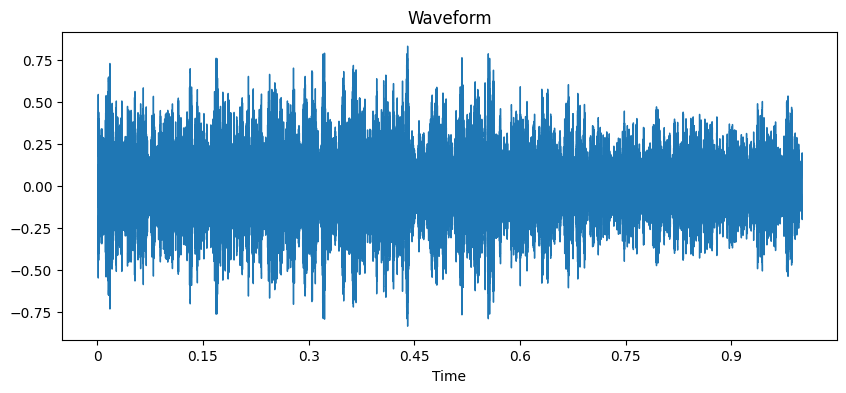

In [15]:
# plot the waveform
import matplotlib.pyplot as plt

def plot_waveform(y, sr, title="Waveform"):
    """Plots the waveform of an audio signal.

    Args:
      y: Audio time series.
      sr: Sampling rate of 'y'.
      title: Title of the plot.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.show()

# Load and plot the waveform of the first audio file
y, sr = load_audio(df_info["file_path"][0])
plot_waveform(y, sr)



In [ ]:
def create_dataframe(data_dir):
    """
    Creates a pandas DataFrame from a directory of audio files.

    Args:
      data_dir: Path to directory containing folders of audio files separated by class

    Returns:
      df: Pandas DataFrame containing features and labels.
    """
    features_list = []
    labels_list = []

    for label in os.listdir(data_dir):  # Iterate through each class
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(".wav"):
                    file_path = os.path.join(class_dir, filename)
                    try:
                        # features = extract_features(file_path)
                        # features_list.append(features)
                        labels_list.append(label)
                    except Exception as e:
                        print(f"Error processing {filename}: {e}")

    # Convert the dictionary of features into a dataframe
    df = pd.DataFrame(features_list)

    # Extract the separate mfcc columns from the 'mfcc' columns
    mfcc_df = pd.DataFrame(
        df["mfcc"].tolist(),
        columns=[f"mfcc_{i}" for i in range(df["mfcc"].iloc[0].shape[0])],
    )
    df = pd.concat([df, mfcc_df], axis=1).drop("mfcc", axis=1)

    # Extract the separate chroma columns from the 'chroma' columns
    chroma_df = pd.DataFrame(
        df["chroma"].tolist(),
        columns=[f"chroma_{i}" for i in range(df["chroma"].iloc[0].shape[0])],
    )
    df = pd.concat([df, chroma_df], axis=1).drop("chroma", axis=1)

    # Add the labels
    df["label"] = labels_list

    return df